# Многопоточное программирование - реализация различных алгоритмов

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
from matplotlib import cm
from scipy.optimize import curve_fit
import pandas as pd
import time

### Алгоритм Монте - Карло для оценки числа $\pi$

In [2]:
def one_test(executableName, filename) -> None:
    global path
    global estimations, time 
    result = subprocess.Popen([path+executableName], stdout = subprocess.PIPE)
    stdout, stderr = result.communicate()
    time.append(int(stdout.decode('utf-8').split(' ')[1]))
    estimations.append(np.loadtxt(filename))

In [23]:
path = r'/home/vladimir/BOTAY!/CplusplusHOMEWORK/lesson_2_7/'
executableName_1 = r'pi_one_thread'
exeecutableName_2 = r'mont_8_threads'
estimations = []
time = []
iter_depth = int(1e5)

In [24]:
for _ in range(50):
    one_test(executableName = executableName_1, filename = 'exp_1.txt')

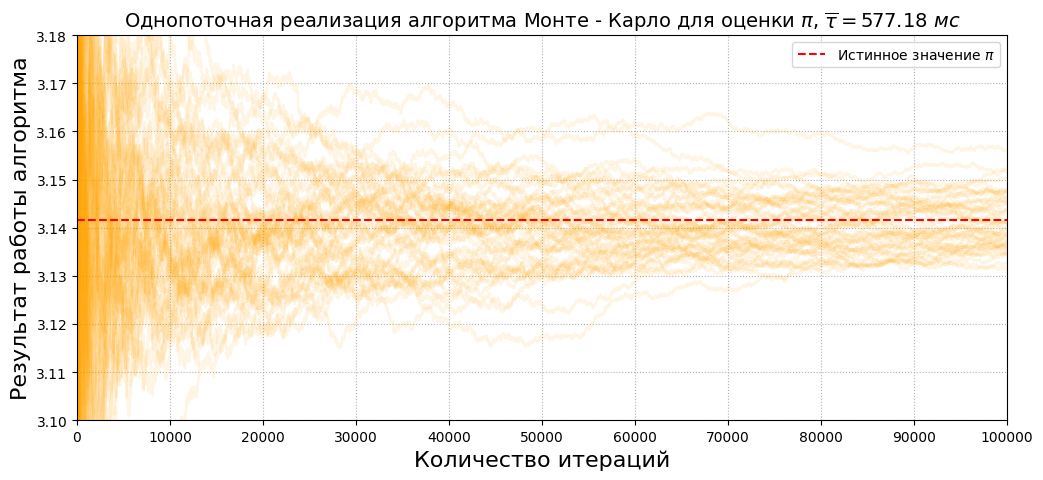

In [25]:
plt.figure(figsize = (12, 5))
sizes = np.arange(iter_depth) + 1

for ind, est in enumerate(estimations):
    plt.plot(sizes, 
             est, 
             alpha = 0.1, 
             color = 'orange')

plt.grid(ls = ':')
plt.ylim(3.1, 3.18)
plt.axhline(np.pi, color = 'red', linestyle = '--', label = r'Истинное значение $\pi$')
plt.xticks(np.arange(0, iter_depth + 1e4, 1e4))
plt.xlim(0, iter_depth)

plt.legend()
plt.xlabel("Количество итераций", fontsize = 16)
plt.ylabel("Результат работы алгоритма", fontsize = 16)
plt.title(r"Однопоточная реализация алгоритма Монте - Карло для оценки $\pi$, $\overline{\tau} = " \
           + str(np.round(np.mean(time), 2)) + "\ мс$", fontsize = 14);

In [26]:
estimations = []
time = []
for _ in range(50):
    one_test(executableName = exeecutableName_2, filename = 'exp_2.txt')

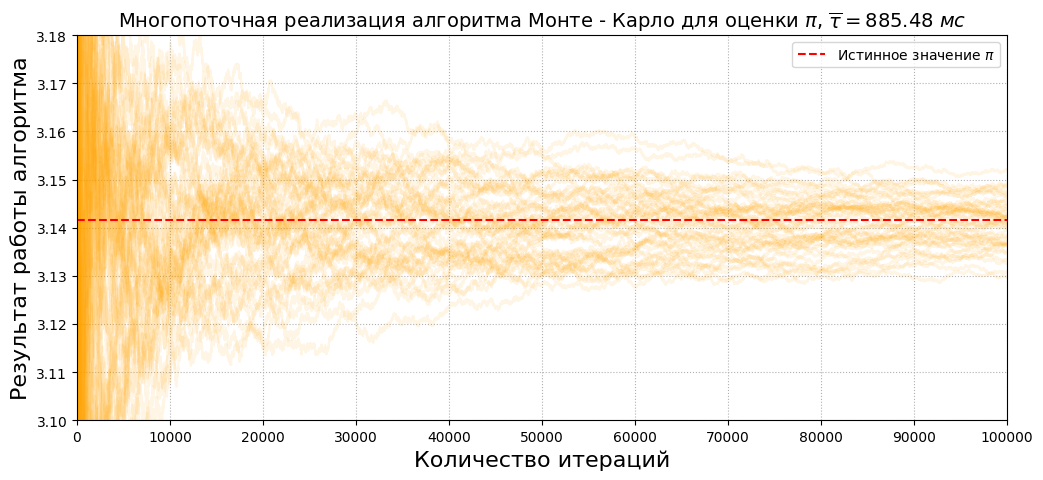

In [27]:
plt.figure(figsize = (12, 5))
sizes = np.arange(iter_depth) + 1

for ind, est in enumerate(estimations):
    plt.plot(sizes, 
             est, 
             alpha = 0.1, 
             color = 'orange')

plt.grid(ls = ':')
plt.ylim(3.1, 3.18)
plt.axhline(np.pi, color = 'red', linestyle = '--', label = r'Истинное значение $\pi$')
plt.xticks(np.arange(0, iter_depth + 1e4, 1e4))
plt.xlim(0, iter_depth)

plt.legend()
plt.xlabel("Количество итераций", fontsize = 16)
plt.ylabel("Результат работы алгоритма", fontsize = 16)
plt.title(r"Многопоточная реализация алгоритма Монте - Карло для оценки $\pi$, $\overline{\tau} = " \
           + str(np.round(np.mean(time), 2)) + "\ мс$", fontsize = 14);

## Многопоточное умножение матриц(оптимизация только для квадратных матриц)

Напишем функции, необходимые для проведения эксперимента. Наша программа принимает 5 консольных аргументов

- arg1 - количество строк матрицы A
- arg2 - количество столбцов матрицы A 
- arg3 - количество строк матрицы B
- arg4 - количество столбцов матрицы B
- arg5 - количество потоков

`main.cpp` реализован так:
```cpp
#include <iostream>
#include <chrono>
#include <vector>
#include <thread>
#include <future>
#include "logDuration.hpp"
#include "matrix.hpp"

int main(int argc, char** argv)
{
    auto A = Matrix(atoi(argv[1]), atoi(argv[2]), true, atoi(argv[5]));
    auto B = Matrix(atoi(argv[3]), atoi(argv[4]), true, atoi(argv[5]));
    
    std::ofstream out_a;
    out_a.open("A.txt");
    std::ofstream out_b;
    out_b.open("B.txt");
    std::ofstream out_c;
    out_c.open("C.txt");

    A.write_matrix(out_a);
    B.write_matrix(out_b);

    Matrix C = A*B;
    C.write_matrix(out_c);
    return 0;
}
```

В конструкторе класса `Matrix` генерируется матрица состоящая из равномерно распределенных случайных чисел. После чего матрицы записываются в файлы `A.txt` и `B.txt`. Для записи используется простенький метод `write_matrix`. 

Матрица `C` получается умножением матрицы `A` на матрицу `B`. В реализации метода матричного умножения создаётся объект класса `logDuration` - инициализируется счетчик времени. По завершении операции объект выходит из области видимости метода и вызвается его деструктор. В деструкторе реализован вывод итогового времени работы в консоль

Скомпилируем нашу программу:
```bash
g++ -c main.cpp -funroll-loops -ftree-vectorize -ftree-vectorizer-verbose=1 -pthread
g++ -c matrix.cpp -funroll-loops -ftree-vectorize -ftree-vectorizer-verbose=1 -pthread
g++ -o mat main.o matrix.o
```

Дополнительные аргументы указываем для включения автоматической векторизации циклов(авось поможет). 


In [3]:
path = r'/home/vladimir/BOTAY!/CplusplusHOMEWORK/lesson_2_7/matrix_mult/'
executableName = 'mat'

Укажем путь к скомпилированной программе. При помощи библиотеки `subprocess` будем запускать нашу программу, передавая ей необходимые консольные аргументы:

In [4]:
def execute(a_shape, b_shape, thread_count = 8) -> int:
    """Запускает написанную программу

    Args:
        a_shape (int, int): Размер левой матрицы
        b_shape (_type_): Размер правой матрицы
        thread_count (int, optional): Количество потоков

    Returns:
        int: Время работы в миллисекундах
    """
    global path, executableName
    result = subprocess.Popen([path+executableName, str(a_shape[0]), str(a_shape[1]), str(b_shape[0]), str(b_shape[1]), str(thread_count)], stdout = subprocess.PIPE)
    stdout, stderr = result.communicate()
    return int(stdout.decode('utf-8').split(' ')[1])

Также реализуем функцию, которая сравнивает результат выполнения программы с результатом, полученным при помощи библиотеки `numpy`:

In [5]:
def check_truth() -> bool:
    """Проверяет верно ли наша программа умножила матрицы

    Returns:
        bool: похож ли результат умножения на результат метода `numpy`
    """
    a = np.loadtxt("A.txt").astype(np.int64)
    b = np.loadtxt("B.txt").astype(np.int64)
    c = np.loadtxt("C.txt").astype(np.int64)
    return np.allclose(a @ b, c)

In [6]:
a_shape, b_shape = (100, 100), (100, 100)
execute(a_shape, b_shape, 8)

3

In [7]:
check_truth()

True

In [8]:
size_values = np.arange(100, 1000, 50)
thread_num_values = np.arange(8) + 1
time_different_threads_num = {th: [] for th in thread_num_values}
time_different_threads_num['numpy'] = []
for thread_num in thread_num_values:
    for size in size_values:
        time_different_threads_num[thread_num].append(execute((size, size), (size, size), thread_num))
        a = np.loadtxt("A.txt")
        b = np.loadtxt("B.txt")
        c = np.loadtxt("C.txt")
        if thread_num == 8:
            time_point = time.time()
            c_numpy = a @ b
            time_different_threads_num["numpy"].append(time.time() - time_point)
        c_numpy = a @ b
        assert(np.allclose(c, c_numpy))

##### Результат эксперимента

In [22]:
time_different_threads_num_df = pd.DataFrame(time_different_threads_num)
time_different_threads_num_df['matrix_size'] = size_values
time_different_threads_num_df.set_index('matrix_size')
time_different_threads_num_df.to_markdown()

'|    |     1 |    2 |    3 |    4 |    5 |    6 |    7 |    8 |       numpy |   matrix_size |\n|---:|------:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|------------:|--------------:|\n|  0 |     6 |   13 |   11 |   12 |   12 |   11 |    7 |    6 | 0.00410628  |           100 |\n|  1 |    50 |   34 |   25 |   22 |   22 |   14 |   38 |   14 | 0.000277758 |           150 |\n|  2 |   117 |   77 |   59 |   56 |   41 |   51 |   42 |   49 | 0.0035522   |           200 |\n|  3 |    95 |  112 |  105 |   90 |   68 |   74 |   59 |   90 | 0.000525475 |           250 |\n|  4 |   225 |  141 |  103 |  119 |  112 |   98 |  108 |  105 | 0.00979662  |           300 |\n|  5 |   433 |  159 |   72 |  119 |  116 |   78 |  113 |  128 | 0.00104785  |           350 |\n|  6 |   712 |  219 |  149 |   89 |  156 |  117 |  103 |  117 | 0.00194335  |           400 |\n|  7 |   864 |  272 |  234 |  247 |  192 |  181 |  157 |  189 | 0.00334263  |           450 |\n|  8 |  1577 |  439 |  241 |  185 |  231 |  227 |

В результате эксперимента получили следующие данные

| Номер эксперимента   |     1 поток |    2 потока |    3 потока|    4 потока |    5 потоков |    6 потоков|    7 потоков |    8 потоков |       numpy |   Размер матрицы |
|---:|------:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|------------:|--------------:|
|  0 |     6 |   13 |   11 |   12 |   12 |   11 |    7 |    6 | 0.00410628  |           100 |
|  1 |    50 |   34 |   25 |   22 |   22 |   14 |   38 |   14 | 0.000277758 |           150 |
|  2 |   117 |   77 |   59 |   56 |   41 |   51 |   42 |   49 | 0.0035522   |           200 |
|  3 |    95 |  112 |  105 |   90 |   68 |   74 |   59 |   90 | 0.000525475 |           250 |
|  4 |   225 |  141 |  103 |  119 |  112 |   98 |  108 |  105 | 0.00979662  |           300 |
|  5 |   433 |  159 |   72 |  119 |  116 |   78 |  113 |  128 | 0.00104785  |           350 |
|  6 |   712 |  219 |  149 |   89 |  156 |  117 |  103 |  117 | 0.00194335  |           400 |
|  7 |   864 |  272 |  234 |  247 |  192 |  181 |  157 |  189 | 0.00334263  |           450 |
|  8 |  1577 |  439 |  241 |  185 |  231 |  227 |  206 |  223 | 0.00556421  |           500 |
|  9 |  2066 |  595 |  457 |  262 |  316 |  305 |  291 |  369 | 0.00531411  |           550 |
| 10 |  1775 |  748 |  471 |  330 |  425 |  386 |  372 |  434 | 0.0260124   |           600 |
| 11 |  4127 | 1287 |  830 |  608 |  617 |  576 |  487 |  602 | 0.00714707  |           650 |
| 12 |  5777 | 1560 |  947 |  918 |  814 |  695 |  615 |  716 | 0.00759196  |           700 |
| 13 |  5337 | 2272 | 1424 | 1213 | 1098 |  924 |  811 |  878 | 0.0127971   |           750 |
| 14 |  4237 | 1950 | 1226 |  973 | 1244 | 1031 |  947 | 1146 | 0.011306    |           800 |
| 15 |  7853 | 3694 | 2324 | 1757 | 1839 | 1525 | 1446 | 1393 | 0.0232015   |           850 |
| 16 |  8817 | 4318 | 2493 | 1816 | 2146 | 1898 | 1831 | 1656 | 0.0285475   |           900 |
| 17 | 11039 | 5120 | 3086 | 2973 | 2766 | 2386 | 2224 | 2089 | 0.03089     |           950 |

Написанный алгоритм работает гораздо медленнее чем реализация `numpy`. Почему так происходит:
- Ассимптотика алгоритма, реализованного в `numpy` - $\sim O(N^{2.3})$
- `numpy` написан на низкоуровневых языках типа `assembler`, `fortran`

Наш алгоритм работает за $O(N^{3})$. Методом `curve_fit` оценим константу, которая скрывается под $O$. Теоретически, для $n$ - поточного алгоритма эта константа в $n$ раз меньше чем для однопоточного. 

In [9]:
def func_interp(x, o_time):
    return o_time * np.power(x, 3)

In [24]:
interp_time_args = {thread_num: curve_fit(func_interp, size_values, time_different_threads_num[thread_num])[0][0]
                    for thread_num in list(thread_num_values) + ['numpy']}
interp_time_args

{1: 1.2311060918598761e-05,
 2: 5.465269216847246e-06,
 3: 3.324151354289891e-06,
 4: 2.7790636181508813e-06,
 5: 2.864800881604325e-06,
 6: 2.465962106988829e-06,
 7: 2.30294143812774e-06,
 8: 2.2835620777231836e-06,
 'numpy': 3.579865376848727e-11}

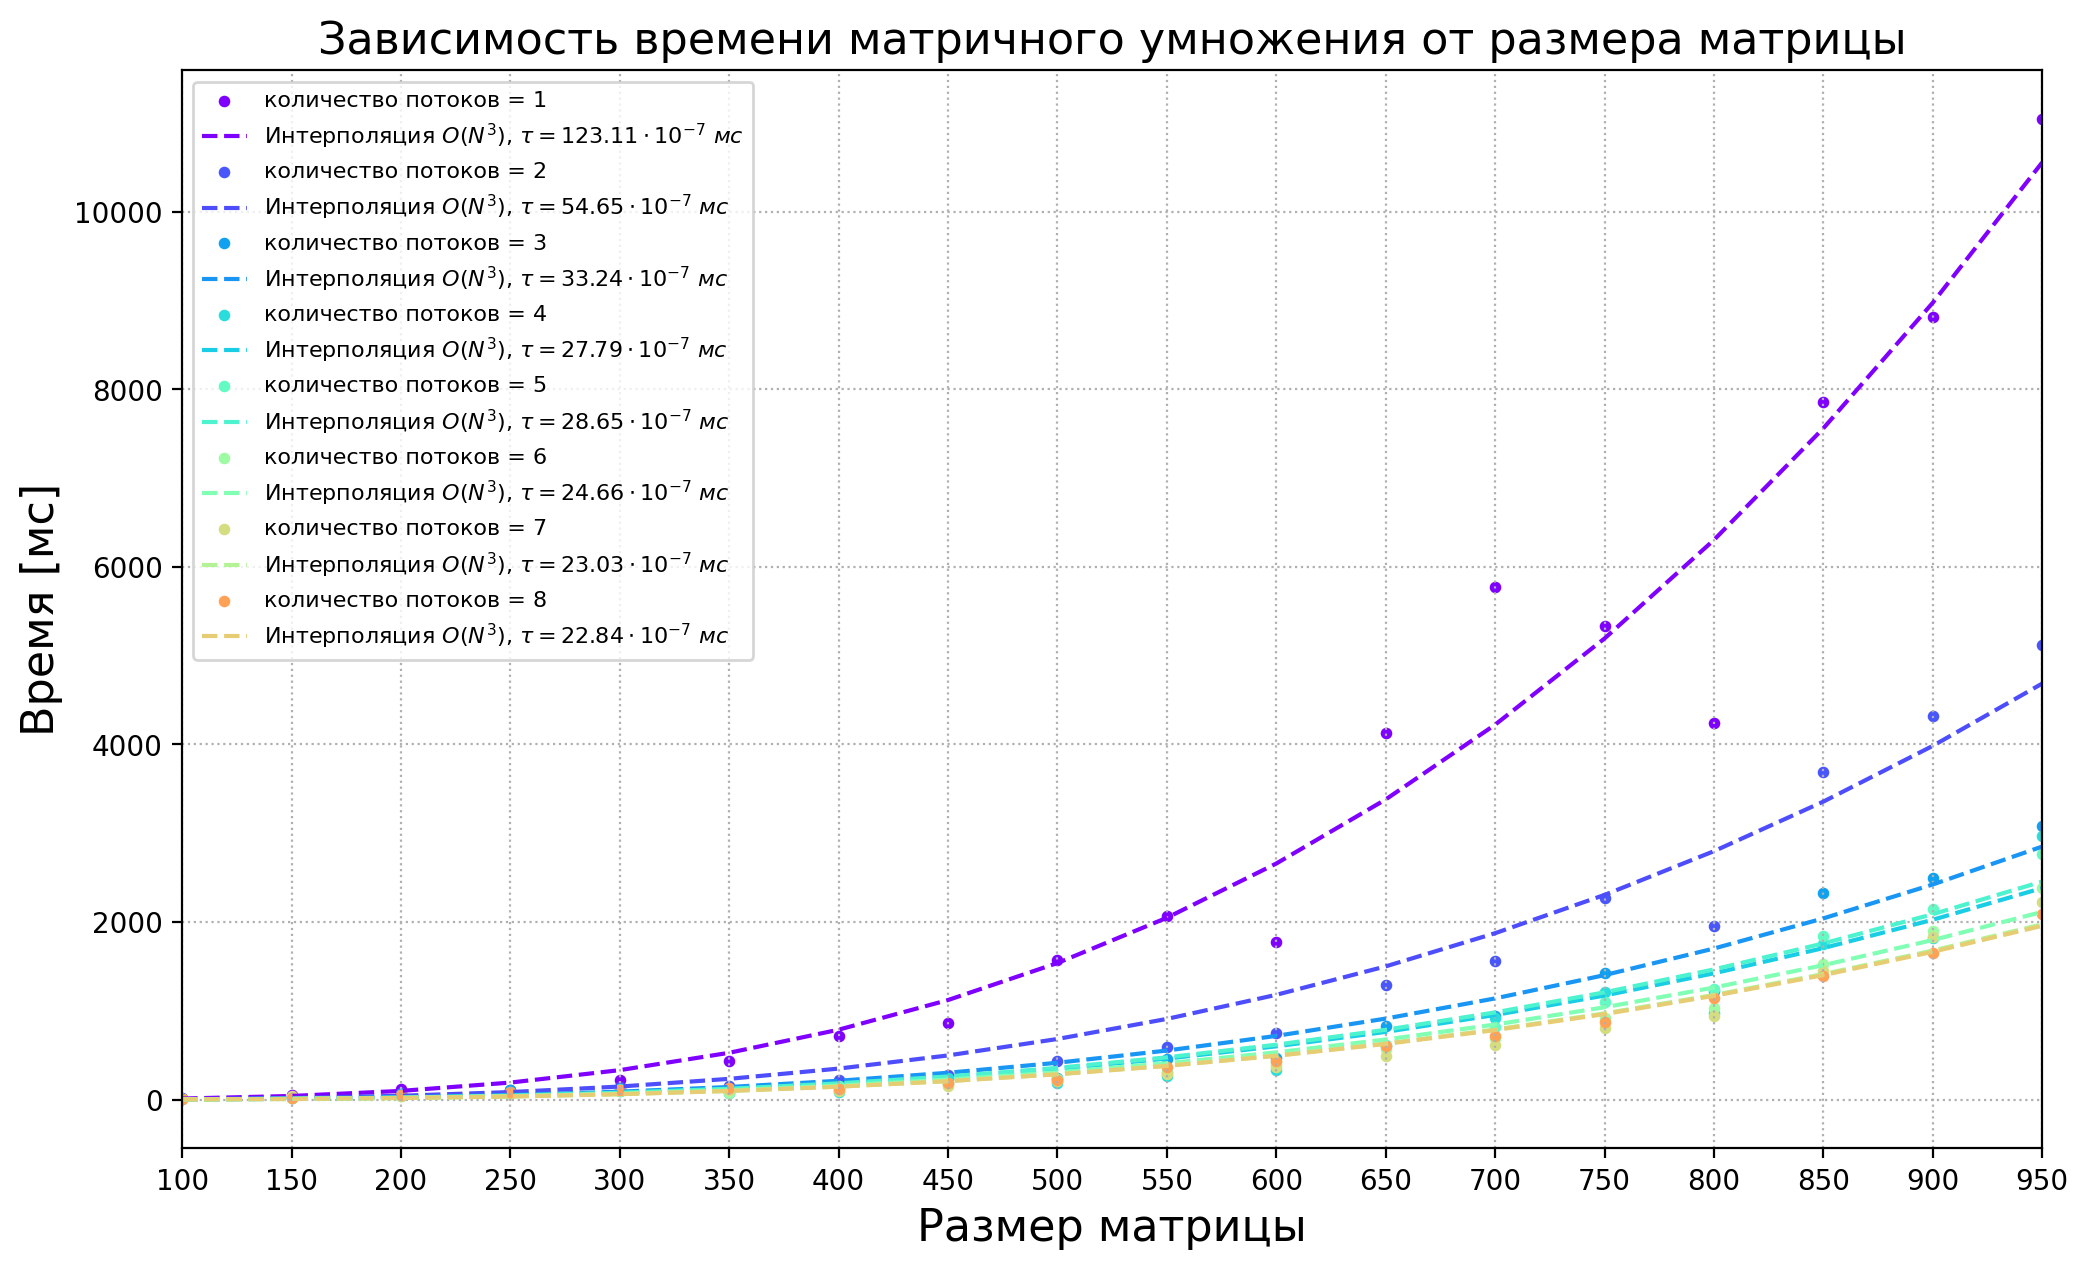

In [23]:
plt.figure(figsize = (12, 7), dpi = 200)

for ind, (name, data) in enumerate(time_different_threads_num.items()):
    label = str(name)
    if name != 'numpy':
        label = f'количество потоков = {name}'
    
    if name != 'numpy':
        color = cm.rainbow(ind / (1 + len(time_different_threads_num)))
        plt.scatter(size_values, 
                    data, 
                    label = label, 
                    color = cm.rainbow(ind / len(time_different_threads_num)),
                    s = 10)
        plt.plot(size_values, 
                func_interp(size_values, interp_time_args[name]),
                linestyle = '--',
                color = color,
                label = r'Интерполяция $O(N^{3})$, $\tau = ' + \
                        f"{np.power(10, 7) * interp_time_args[name]:.2f}" + \
                        "\cdot 10^{-7} \ мс$")

plt.legend(loc = 'upper left', fontsize = 8)
plt.title("Зависимость времени матричного умножения от размера матрицы", fontsize = 16)
plt.ylabel("Время [мс]", fontsize = 16)
plt.xlabel("Размер матрицы", fontsize = 16)
plt.xticks(np.arange(100, 1000, 50))
plt.xlim(100, 950)
plt.grid(ls = ':');

Как видим, гипотеза не совсем верна. Двупоточная реализация работает в два раза быстрее однопоточной 